In [1]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG, Audio
from keras.layers import Dropout
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-11-19 18:36:59.999030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 18:37:01.629552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:37:01.644496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:37:01.644610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [2]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

if not os.path.exists('content'):
  os.makedirs('content/')
  os.makedirs('content/spectrograms3sec_old')
  os.makedirs('content/spectrograms3sec_old/train')
  os.makedirs('content/spectrograms3sec_old/test')

  for g in genres:
    path_audio = os.path.join('content/audio3sec',f'{g}')
    os.makedirs(path_audio)
    path_train = os.path.join('content/spectrograms3sec_old/train',f'{g}')
    path_test = os.path.join('content/spectrograms3sec_old/test',f'{g}')
    os.makedirs(path_train)
    os.makedirs(path_test)


In [4]:
from pydub import AudioSegment
i = 0
for g in genres:
  if len(os.listdir(os.path.join('content/audio3sec/',f"{g}"))) == 0:
    j=0
    print(f"{g}")
    for filename in os.listdir(os.path.join('data/genres',f"{g}")):
      song  =  os.path.join(f'data/genres/{g}',f'{filename}')
      j = j+1
      for w in range(0,10):
        i = i+1
        #print(i)
        t1 = 3*(w)*1000
        t2 = 3*(w+1)*1000
        newAudio = AudioSegment.from_wav(song)
        new = newAudio[t1:t2]
        new.export(f'content/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

In [5]:
for g in genres:
  if len(os.path.join('content/spectrograms3sec_old/train/',f"{g}")) == 0:
    j = 0
    print(g)
    for filename in os.listdir(os.path.join('content/audio3sec',f"{g}")):
      song  =  os.path.join(f'content/audio3sec/{g}',f'{filename}')
      j = j+1
      
      y,sr = librosa.load(song,duration=3)
      #print(sr)
      mels = librosa.feature.melspectrogram(y=y,sr=sr)
      fig = plt.Figure()
      canvas = FigureCanvas(fig)
      p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
      plt.savefig(f'content/spectrograms3sec_old/train/{g}/{g+str(j)}.png')

In [8]:
directory = "content/spectrograms3sec_old/train/"
for g in genres:
  if len(os.listdir(os.path.join('content/spectrograms3sec_old/test/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:200]

    for f in test_files:

      shutil.move(directory + f"{g}"+ "/" + f,"content/spectrograms3sec_old/test/" + f"{g}")


In [9]:
train_dir = "content/spectrograms3sec_old/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "content/spectrograms3sec_old/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [10]:
def GenreModel(input_shape = (288,432,4),classes=10):
  
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)
  
  X = Dropout(rate=0.3)(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
# checkpoint_path = "saved_cnn2/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

model = GenreModel(input_shape=(288,432,4), classes=10)
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

2022-11-19 18:37:37.566840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 18:37:37.567684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:37:37.568047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:37:37.568156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [12]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 286, 430, 8)       296       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 286, 430, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 143, 215, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 141, 213, 16)      1

In [14]:
if os.path.exists("saved/saved_cnn10_3"):
    model_history = model.load_model("saved/saved_cnn10_3")
else:
    model_history = model.fit_generator(train_generator,epochs=50,validation_data=vali_generator)
    model.save("saved/saved_cnn10_3")

/tmp/ipykernel_435347/3977031050.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator,epochs=50,validation_data=vali_generator)


Epoch 1/50


2022-11-19 18:38:14.434184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2022-11-19 18:38:15.728001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 72s 1s/step - loss: 2.1493 - accuracy: 0.3474 - get_f1: 0.2939 - val_loss: 2.6538 - val_accuracy: 0.1000 - val_get_f1: 0.0000e+00
Epoch 2/50
63/63 [==============================] - 68s 1s/step - loss: 1.2615 - accuracy: 0.5566 - get_f1: 0.5354 - val_loss: 3.6786 - val_accuracy: 0.1000 - val_get_f1: 0.1324
Epoch 3/50
63/63 [==============================] - 68s 1s/step - loss: 0.9947 - accuracy: 0.6556 - get_f1: 0.6426 - val_loss: 5.8202 - val_accuracy: 0.1000 - val_get_f1: 0.1000
Epoch 4/50
63/63 [==============================] - 68s 1s/step - loss: 0.8618 - accuracy: 0.7014 - get_f1: 0.6979 - val_loss: 4.6165 - val_accuracy: 0.1520 - val_get_f1: 0.1263
Epoch 5/50
63/63 [==============================] - 68s 1s/step - loss: 0.7386 - accuracy: 0.7418 - get_f1: 0.7396 - val_loss: 3.5759 - val_accuracy: 0.3795 - val_get_f1: 0.3826
Epoch 6/50
63/63 [==============================] - 68s 1s/step - loss: 0.6120 - accuracy: 0.7894 - get_f1: 0.7868 - 

INFO:tensorflow:Assets written to: saved/saved_cnn10_3/assets


INFO:tensorflow:Assets written to: saved/saved_cnn10_3/assets


Text(0, 0.5, 'Accuracy [%]')

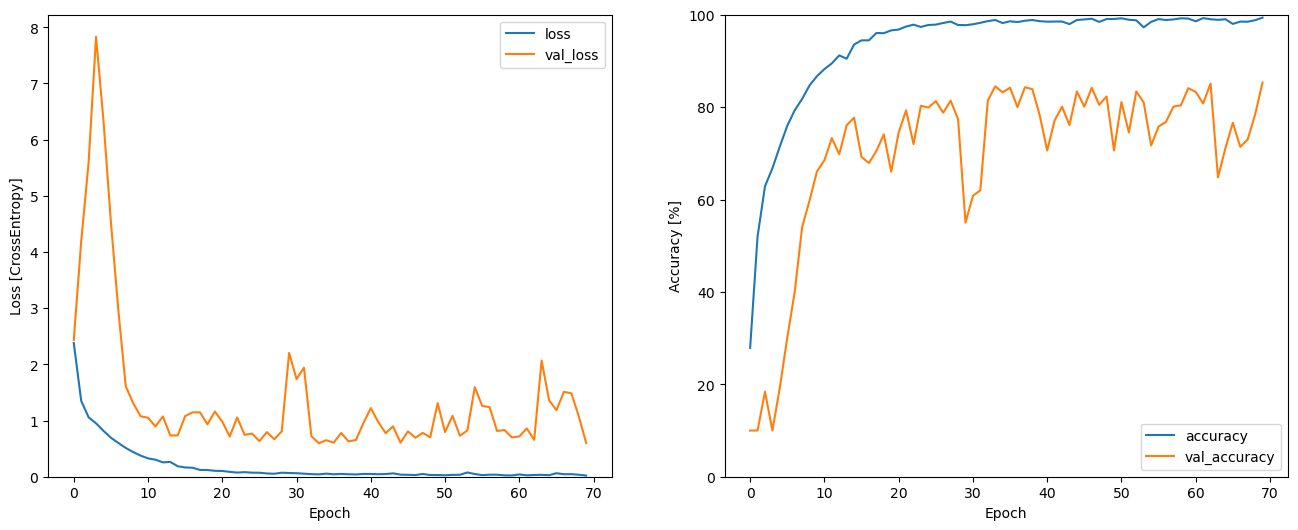

In [12]:
metrics = model_history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(model_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [13]:
test_loss, test_acc, _ = model.evaluate(vali_generator, batch_size=128)
print("The test Loss is :", test_loss)
print("\nThe Best test Accuracy is :", test_acc*100)

8/8 [==============================] - 7s 860ms/step - loss: 0.6013 - accuracy: 0.8530 - get_f1: 0.8564
The test Loss is : 0.6012821197509766

The Best test Accuracy is : 85.29999852180481


In [14]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, genres)
figsize = (12,12)

x, y = zip(*(vali_generator[i] for i in range(len(vali_generator))))
x_val, y_val = np.vstack(x), np.vstack(y)
y_val = np.argmax(y_val, axis=1)

32/32 [==============================] - 1s 11ms/step


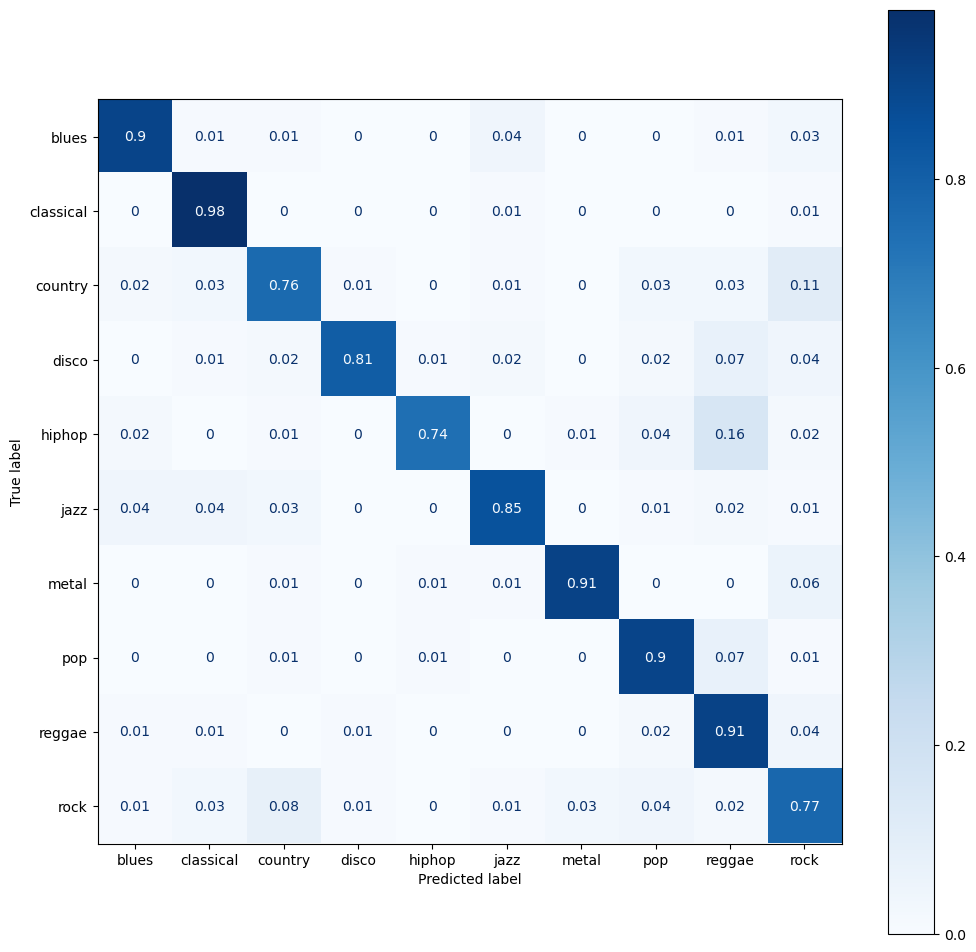

In [15]:
ConfusionMatrixDisplay.from_estimator(classifier, x_val, y_val, cmap='Blues', display_labels=genres ,normalize='true', ax=plt.subplots(figsize=figsize)[1])

1/1 [==============================] - 0s 11ms/step


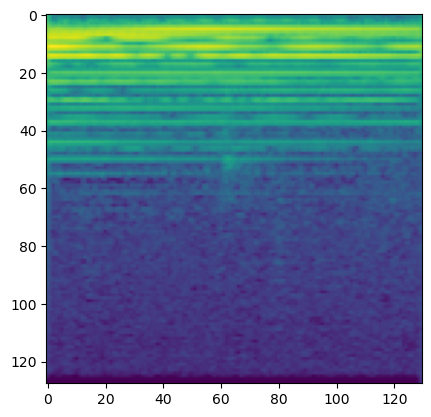

In [16]:
import pathlib
input_dir = pathlib.Path("input/")
audio_file_name = "chopin.wav"
sample_dir = "input/samples/"
audio_seg_dir = "input/audio_segments/"

predictions = []

if not input_dir.exists():
    os.mkdir("input")
    os.mkdir(sample_dir)
    os.mkdir(audio_seg_dir)

sample, sample_sr = librosa.load(os.path.join(sample_dir, audio_file_name))
sample_duration = int(librosa.get_duration(y=sample, sr=sample_sr))
Audio(sample, rate=sample_sr)

for i in range(int(sample_duration/3)): 
    t1 = i * 3 * 1000 #Works in milliseconds
    t2 = (i+1) * 3 * 1000
    newAudio = AudioSegment.from_wav(os.path.join(sample_dir, audio_file_name))
    newAudio = newAudio[t1:t2]
    newAudio.export(audio_seg_dir + 'audio_seg_' + str(i) +'.wav', format="wav") #Exports to a wav file in the current path.

from keras.utils import load_img, img_to_array

for af in os.listdir(audio_seg_dir):
    audio, sr = librosa.load(os.path.join(audio_seg_dir, af))
    mels = librosa.feature.melspectrogram(y=audio,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))

    spec_dir = "input/specs_segments"

    if not os.path.exists(spec_dir):
        os.mkdir(spec_dir)

    plt.savefig(os.path.join(spec_dir, af[:-3] + 'png'))

    image_data = load_img(os.path.join(spec_dir, af[:-3] + 'png'),color_mode='rgba',target_size=(288,432))
    image = img_to_array(image_data)
    image = np.reshape(image,(1,288,432,4))

    p = model.predict(image/255)
    p = p.reshape((10,))

    predictions.append(p)

In [17]:
avg_preds = [x / len(predictions) for x in np.array(predictions).sum(axis=0)]
predicted_label = np.argmax(avg_preds)

print("The Predicted Label was: " + genres[predicted_label])

The Predicted Label was: classical


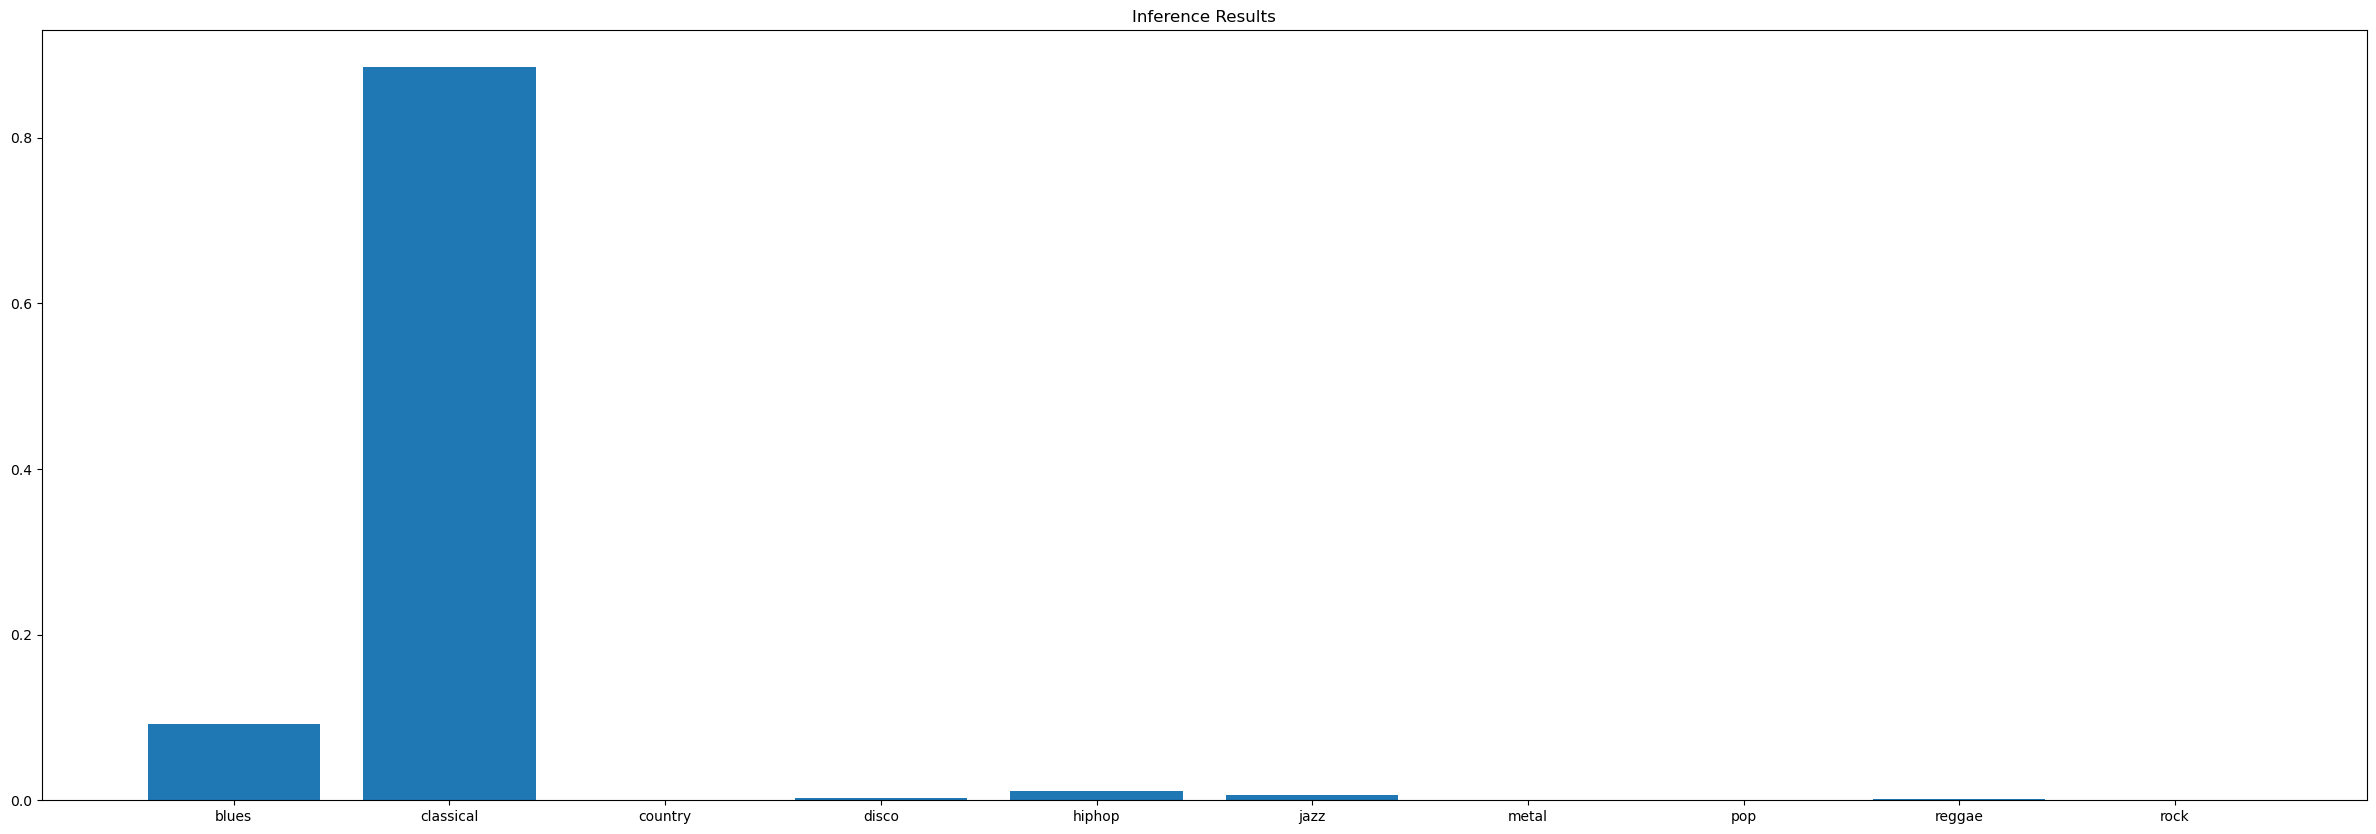

In [18]:
plt.figure(figsize=(30,10))
plt.bar(genres, np.array(avg_preds))
plt.title("Inference Results")
plt.show()